In [1]:
import ee
import datetime
import os
import itertools
import sys
import collections

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap


In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

# append the parent path into sys-path so wen can import necessary modules
sys.path.append('../../')

In [3]:
from BackGround_modules.Class_1_Make_fourier_imgs      import Make_Fourier
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

#### Step_0_Define_Basic_Parameters

In [4]:
# define the number of random points for residule calculation
point_num = 100

# define the max harmonic number that will be tested
harmo_num = 6

In [5]:
# Define the time-range
# just get one_range from every different sensors
year_range = [(f'{i}-01-01',f'2019-12-31') for i in range(2015,2020)] + \
             [(f'{i}-01-01',f'2013-12-31') for i in range(2009,2014)] + \
             [(f'{i}-01-01',f'2010-12-31') for i in range(2006,2011)]


In [6]:
year_range

[('2015-01-01', '2019-12-31'),
 ('2016-01-01', '2019-12-31'),
 ('2017-01-01', '2019-12-31'),
 ('2018-01-01', '2019-12-31'),
 ('2019-01-01', '2019-12-31'),
 ('2009-01-01', '2013-12-31'),
 ('2010-01-01', '2013-12-31'),
 ('2011-01-01', '2013-12-31'),
 ('2012-01-01', '2013-12-31'),
 ('2013-01-01', '2013-12-31'),
 ('2006-01-01', '2010-12-31'),
 ('2007-01-01', '2010-12-31'),
 ('2008-01-01', '2010-12-31'),
 ('2009-01-01', '2010-12-31'),
 ('2010-01-01', '2010-12-31')]

#### Step_1_Triple loop to create GEE_instaces for later residule computation

In [18]:
# get the regions
regions = ['华东','东北','中南','华北','西北','西南']

# innitialize the list that holds residule vlaue
point_with_residule = {}


for region in regions:

    # imprt research_area boundary
    Target_area = ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/China_zone")\
                          .filterMetadata('NAME1','equals',region)
    
    # get random points
    random_point = ee.FeatureCollection.randomPoints(Target_area, point_num, 101).toList(point_num).getInfo()
    
    # print out the region under processing
    print(f'Construct residule instances for {region}.')


    # __________________________________loop through the year_range________________________________
    for span in year_range:

        # define the start and end of time
        start = span[0]
        end   = span[1]
        spane_len = str(int(end[:4]) - int(start[:4]))

        # get span_name for export
        split = '-'
        span_name = f'{start.split(split)[0]}_{end.split(split)[0]}'


        # __________________________________loop through harmonics ________________________________
        for harmonic in range(1,harmo_num + 1):

            # make a residule img 
            Fourier_making = Make_Fourier(start_date=start,end_date=end,harmonics=harmonic,area=Target_area)
            Fourier_making.Stp_1_Create_hamonic_names()
            Fourier_making.Stp_2_Add_harmonics()
            Fourier_making.Stp_3_Harmonic_fit()

            # get the Residule img.
            Residule_img = ee.ImageCollection(Fourier_making.harmonicTrendResidule)


            # ______________________________loop through each point _______________________________
            for pt in random_point:
                
                # get the id of the point
                pt_id = pt['id']

                # calculate the residule, this is ght 3rd level of the dict
                point_with_residule[(region,span_name,harmonic,int(pt_id))] = Residule_img.getRegion(pt['geometry'],30)

##### Step_2_Unpack the residule values

In [ ]:
# set opration flag to report the process
ops_num   = 0
ops_total = len(regions) * len(year_range) * harmo_num * point_num

# initiate an empty list to hold the residule_dfs
Residule = []

# loop through the dict and unpack the values
for key in point_with_residule.keys():

    # unpack the value
    residule = point_with_residule[key].getInfo()

    # construct the redidule df
    col = residule[0]
    val = residule[1]
    df = pd.DataFrame([val],columns = col,index=[key])

    # add the df to list
    Residule.append(df)

    # print out the process
    ops_num = ops_num + 1
    print(f'Unpack {key} successful!  ==>{ops_num}/{ops_total}')

Unpack ('华东', '2015_2019', 1, 0) successful!  ==>1/54000
Unpack ('华东', '2015_2019', 1, 1) successful!  ==>2/54000
Unpack ('华东', '2015_2019', 1, 2) successful!  ==>3/54000
Unpack ('华东', '2015_2019', 1, 3) successful!  ==>4/54000
Unpack ('华东', '2015_2019', 1, 4) successful!  ==>5/54000
Unpack ('华东', '2015_2019', 1, 5) successful!  ==>6/54000
Unpack ('华东', '2015_2019', 1, 6) successful!  ==>7/54000
Unpack ('华东', '2015_2019', 1, 7) successful!  ==>8/54000
Unpack ('华东', '2015_2019', 1, 8) successful!  ==>9/54000
Unpack ('华东', '2015_2019', 1, 9) successful!  ==>10/54000
Unpack ('华东', '2015_2019', 1, 10) successful!  ==>11/54000
Unpack ('华东', '2015_2019', 1, 11) successful!  ==>12/54000
Unpack ('华东', '2015_2019', 1, 12) successful!  ==>13/54000
Unpack ('华东', '2015_2019', 1, 13) successful!  ==>14/54000
Unpack ('华东', '2015_2019', 1, 14) successful!  ==>15/54000
Unpack ('华东', '2015_2019', 1, 15) successful!  ==>16/54000
Unpack ('华东', '2015_2019', 1, 16) successful!  ==>17/54000
Unpack ('华东', '2

Unpack ('华东', '2015_2019', 2, 39) successful!  ==>140/54000
Unpack ('华东', '2015_2019', 2, 40) successful!  ==>141/54000
Unpack ('华东', '2015_2019', 2, 41) successful!  ==>142/54000
Unpack ('华东', '2015_2019', 2, 42) successful!  ==>143/54000
Unpack ('华东', '2015_2019', 2, 43) successful!  ==>144/54000
Unpack ('华东', '2015_2019', 2, 44) successful!  ==>145/54000
Unpack ('华东', '2015_2019', 2, 45) successful!  ==>146/54000
Unpack ('华东', '2015_2019', 2, 46) successful!  ==>147/54000
Unpack ('华东', '2015_2019', 2, 47) successful!  ==>148/54000
Unpack ('华东', '2015_2019', 2, 48) successful!  ==>149/54000
Unpack ('华东', '2015_2019', 2, 49) successful!  ==>150/54000
Unpack ('华东', '2015_2019', 2, 50) successful!  ==>151/54000
Unpack ('华东', '2015_2019', 2, 51) successful!  ==>152/54000
Unpack ('华东', '2015_2019', 2, 52) successful!  ==>153/54000
Unpack ('华东', '2015_2019', 2, 53) successful!  ==>154/54000
Unpack ('华东', '2015_2019', 2, 54) successful!  ==>155/54000
Unpack ('华东', '2015_2019', 2, 55) succes

In [20]:
Residule_df

,Year,Harmonic,Point,Index,Value,Span,Sensor,Mean_Err
0,2015_2019,1,0,NDVI,144.0,5,Landsat_8,28.8
1,2015_2019,1,0,NDBI,153.0,5,Landsat_8,30.6
2,2015_2019,1,0,EVI,99.0,5,Landsat_8,19.8
3,2015_2019,1,1,NDVI,178.0,5,Landsat_8,35.6
4,2015_2019,1,1,NDBI,169.0,5,Landsat_8,33.8
...,...,...,...,...,...,...,...,...
44995,2010_2010,10,98,NDBI,NaN,1,Landsat_5,NaN
44996,2010_2010,10,98,EVI,NaN,1,Landsat_5,NaN
44997,2010_2010,10,99,NDVI,NaN,1,Landsat_5,NaN
44998,2010_2010,10,99,NDBI,NaN,1,Landsat_5,NaN


##### Step_3_Read local csv and make plots

##### Save the result to local drive

In [7]:
# save, comment this line in case overwrriting
#Residule_df = pd.DataFrame.from_dict(Residule).T
#Residule_df.to_csv('Step_2_result/Residule.csv')

# read from csv
Residule_df = pd.read_csv('./Reuslt/Residule.csv')
Residule_df.columns = ['Year', 'Harmonic', 'Point', 'Index', 'Value']


# add a time span to df
Residule_df['Span'] = Residule_df['Year'].apply(lambda x: int(x.split('_')[1]) - int(x.split('_')[0]) + 1)

##### Count the Nan value

In [8]:
# get the rows where Value == Nan
Nan_rows = Residule_df[Residule_df['Value'].isna()]

In [9]:
# compute how many nan values exist in differnet year_range
Count_nan_year = collections.Counter(Nan_rows['Year'])

# compute how many nan values exist in differnet harmonic
Count_nan_hamonic = collections.Counter(Nan_rows['Harmonic'])

In [10]:
print(Count_nan_year)
print(Count_nan_hamonic)

Counter({'2013_2013': 813, '2010_2010': 749, '2019_2019': 465, '2012_2013': 74, '2009_2010': 42})
Counter({10: 613, 9: 545, 8: 417, 7: 266, 6: 172, 5: 94, 4: 30, 2: 3, 3: 3})


##### Reshape the dataframe and make figures

Add [Mean-Err] and romove [Value,Point]

In [11]:
# add a column indicating which sensor is
Landsat_8_range = ['2015_2019', '2016_2019', '2017_2019', '2018_2019', '2019_2019']
Landsat_7_range = ['2009_2013', '2010_2013', '2011_2013', '2012_2013', '2013_2013']
Landsat_5_range = ['2006_2010', '2007_2010', '2008_2010', '2009_2010', '2010_2010']

# perform the test using nest if else statement.
Residule_df['Sensor'] = Residule_df['Year'].apply(lambda x: 'Landsat_8' if x in Landsat_8_range 
                                                                           else ('Landsat_7' if x in Landsat_7_range 
                                                                             else 'Landsat_5'))

Residule_df['Mean_Err'] = Residule_df['Value']/Residule_df['Span']

Reshape the Residule_df into <br>
1) grouped --> Mean of [Value]  with indicate the magitude of residule <br>
2) single_index --> the single-indexed version of groupd_df, which is used for sns figure making  <br>

In [12]:
# group the dafaframe with point_id and a function of mean
grouped = Residule_df.drop(['Point','Value'],axis=1).groupby(['Sensor','Span','Harmonic','Index']).mean()
single_index = grouped.reset_index(level=[0,1,2,3])

In [13]:
single_index

,Sensor,Span,Harmonic,Index,Mean_Err
0,Landsat_5,1,1,EVI,117.290
1,Landsat_5,1,1,NDBI,103.420
2,Landsat_5,1,1,NDVI,117.240
3,Landsat_5,1,2,EVI,97.370
4,Landsat_5,1,2,NDBI,89.800
...,...,...,...,...,...
445,Landsat_8,5,9,NDBI,24.386
446,Landsat_8,5,9,NDVI,26.476
447,Landsat_8,5,10,EVI,21.274
448,Landsat_8,5,10,NDBI,24.056


##### Observe that Hamonic of 3 (3 pairs of sinuate functions) is good enough to reduce mean error

<AxesSubplot:xlabel='Harmonic', ylabel='Mean_Err'>

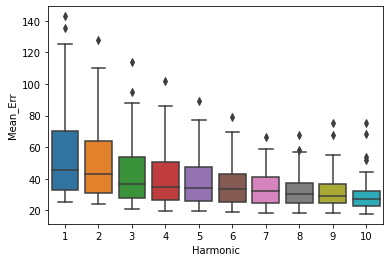

In [14]:
sns.boxplot(x='Harmonic',y = 'Mean_Err',data = single_index)

##### Observe that 3 years composite reduces the mean error significantly

<AxesSubplot:xlabel='Span', ylabel='Mean_Err'>

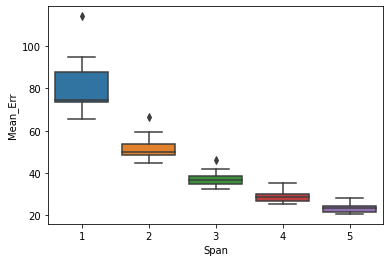

In [15]:
sns.boxplot(data = single_index[single_index['Harmonic'] == 3],
            x='Span',
            y = 'Mean_Err')